In [2]:
print('Hello')

Hello


In [6]:

from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
import random
import pickle

from scipy import stats
from scipy.stats import reciprocal

from IPython.display import display, HTML
from prettytable import PrettyTable

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from skopt import BayesSearchCV

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Embedding, LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Bidirectional
from keras.regularizers import L1L2
from keras.utils import np_utils
from keras_tuner import RandomSearch

import tensorflow as tf

from get_data import txt_to_pd_WISDM
from feature_extraction import tilt_angle
from pre_processing import extract_windows, normalize_data, filter_data
from visualize_data import confusion_matrix, show_performance_DNN


In [10]:
# Create models:

def DNN_model(n_neurons, n_hidden, learning_rate, n_classes=6):
    model = Sequential()
    model.add(Dense(n_neurons, activation='relu'))
    for i in range(n_hidden):
        model.add(Dense(n_neurons, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))

    return model

def LSTM_model(N_NODES, N_CLASSES, TIME_PERIODS, N_FEATURES):
    model = Sequential()
    # RNN layer
    # Bias regularizer value - we will use elasticnet
    model.add(LSTM(units =60, return_sequences=True,
                   input_shape =(TIME_PERIODS,N_FEATURES)))
    model.add(LSTM(units = 60, return_sequences=True,
                     input_shape =(TIME_PERIODS,N_FEATURES)))
    # Dropout layer
    model.add(Dropout(0.5)) 
    # Dense layer with ReLu
    model.add(Dense(units = 64, activation='relu'))
    model.add(Flatten())
    model.add(Dense(N_CLASSES, activation='softmax'))

    return model

In [11]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [12]:
random_seed=42
# Extract data
data = txt_to_pd_WISDM()
# Normalize data [-1,1]: across subjects or
# data = normalize_data(data)

segment_array, segment_labels,LABELS = extract_windows(data, sec=5.5, overlap_prosent=50)
print(segment_array.shape)
# 80% trening, 10% validering, 10% test 
X_train, X_test, y_train, y_test = train_test_split(segment_array, 
        segment_labels, test_size = 0.1, random_state = random_seed)



 # Conduct one-hot-encoding of labels:
y_train_hot = pd.get_dummies(y_train).to_numpy()
y_test_hot = pd.get_dummies(y_test).to_numpy()
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(y_train_hot)

print('Size of training data:')
print(len(X_train), timesteps, input_dim)
print('HERE!')
print(n_classes)
# Initializing parameters:
learning_rate = 0.0001
N_NODES = 40
N_HL = 4
epochs = 40 # one pass over the batch-size dataset
batch_size =  100 #1024

(19732, 110, 3)
Size of training data:
17758 110 3
HERE!
6


In [14]:
# Create model
#model = DNN_model(N_NODES, N_HL, n_classes)
model= LSTM_model(N_NODES, n_classes, timesteps, N_FEATURES=input_dim)


In [16]:
# Train model:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(filepath='best_model_'+'.{epoch:02d}-{val_accuracy:.2f}.h5',
                                         monitor='accuracy',mode='max', save_best_only=True), 
        keras.callbacks.TensorBoard(log_dir='./logs'),
        keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',restore_best_weights=True,
                                      verbose=1, patience=5, min_delta=0.001),]
 # config the model  
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer =opt, metrics = ['accuracy'])
# fit the model:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    callbacks=callbacks_list, validation_split= 0.1111, 
                    verbose=1)
print(model.summary())

Epoch 1/40
158/158 [==============================] - 23s 123ms/step - loss: 0.5114 - accuracy: 0.8174 - val_loss: 0.5004 - val_accuracy: 0.8155
Epoch 2/40
158/158 [==============================] - 18s 114ms/step - loss: 0.4809 - accuracy: 0.8299 - val_loss: 0.4774 - val_accuracy: 0.8317
Epoch 3/40
158/158 [==============================] - 18s 115ms/step - loss: 0.4610 - accuracy: 0.8352 - val_loss: 0.4519 - val_accuracy: 0.8383
Epoch 4/40
158/158 [==============================] - 19s 119ms/step - loss: 0.4378 - accuracy: 0.8422 - val_loss: 0.4525 - val_accuracy: 0.8409
Epoch 5/40
158/158 [==============================] - 19s 118ms/step - loss: 0.4226 - accuracy: 0.8476 - val_loss: 0.4496 - val_accuracy: 0.8479
Epoch 6/40
158/158 [==============================] - 18s 114ms/step - loss: 0.4056 - accuracy: 0.8531 - val_loss: 0.4011 - val_accuracy: 0.8571
Epoch 7/40
158/158 [==============================] - 19s 119ms/step - loss: 0.3932 - accuracy: 0.8554 - val_loss: 0.3991 - val_ac

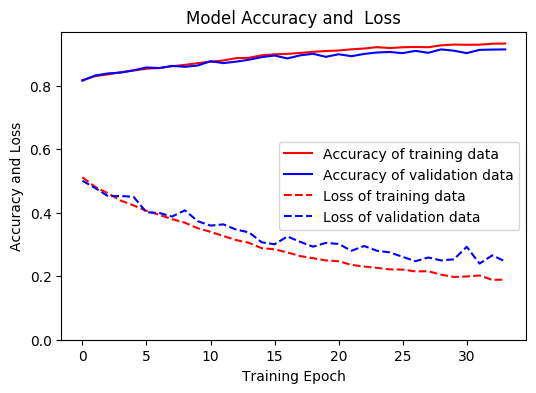

Classification report for test data
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       186
           1       0.98      0.98      0.98       650
           2       0.99      0.98      0.98        99
           3       0.93      0.98      0.96        87
           4       0.83      0.59      0.69       221
           5       0.90      0.98      0.94       731

    accuracy                           0.91      1974
   macro avg       0.90      0.87      0.88      1974
weighted avg       0.91      0.91      0.91      1974


 ********Confusion Matrix********


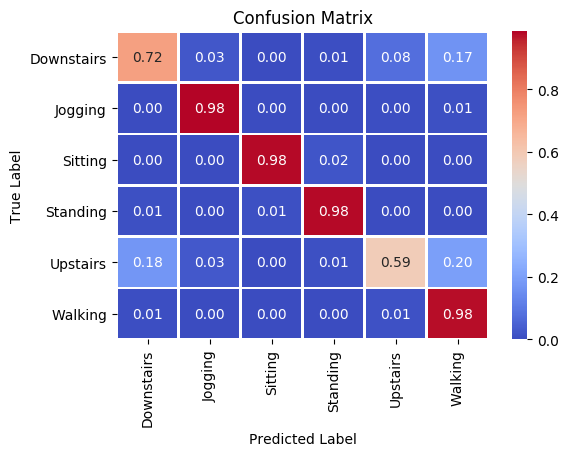

(1974, 110, 3) (1974, 6)
62/62 [==============================] - 1s 23ms/step - loss: 0.2582 - accuracy: 0.9119


In [17]:
# visualize the training performance:
show_performance_DNN(history)
performance = {}
performance['model'] = model

# Evaluate score on test data: (ONLY AFTER TRAINING MODEL!!!)
# Test data performance
y_pred_test = model.predict(X_test)
best_class_pred_test = np.argmax(y_pred_test, axis=1)
best_class_test = np.argmax(y_test_hot, axis=1)

print('Classification report for test data')
print(classification_report(best_class_test, best_class_pred_test))
confusion_matrix(best_class_test, best_class_pred_test, LABELS, normalize=True)

# Evaluation score: categorical cross-entropy and accuracy
print(X_test.shape,y_test_hot.shape)
score = model.evaluate(X_test, y_test)
performance['Test score'] = score